Exercise 7.3 - General Comment


In [7]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tabulate import tabulate

from tensorflow import keras

from keras.callbacks import EarlyStopping
from keras import regularizers, Input
from keras.layers import Dropout, Activation, Dense, GlobalAveragePooling2D
layers = keras.layers

from tqdm import tqdm

The code block below defines a few helper functions to visualize the results. You do not need to touch them.

In [2]:
def plot_examples(X, Y, n=10):
    """ Plot the first n examples for each of the 10 classes in the CIFAR dataset X, Y """
    fig, axes = plt.subplots(n, 10, figsize=(10, n))
    for l in range(10):
        axes[0, l].set_title(cifar10_labels[l], fontsize="smaller")
        m = np.squeeze(Y) == l  # boolean mask: True for all images of label l
        for i in range(n):
            image = X[m][i].astype("uint8")  # imshow expects uint8
            ax = axes[i, l]
            ax.imshow(image, origin="upper")
            ax.set(xticks=[], yticks=[])
    return fig, ax


def plot_prediction(X, Y, Y_predict):
    """
    Plot image X along with predicted probabilities Y_predict.
    X: CIFAR image, shape = (32, 32, 3)
    Y: CIFAR label, one-hot encoded, shape = (10)
    Y_predict: predicted probabilities, shape = (10)
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

    # plot image
    ax1.imshow(X.astype("uint8"), origin="upper")
    ax1.set(xticks=[], yticks=[])

    # plot probabilities
    ax2.barh(np.arange(10), Y_predict, align="center")
    ax2.set(xlim=(0, 1), xlabel="Score", yticks=[])
    for i in range(10):
        c = "red" if (i == np.argmax(Y)) else "black"
        ax2.text(0.05, i, cifar10_labels[i].capitalize(), ha="left", va="center", color=c)



def plot_confusion(Y_true, Y_predict):
    """
    Plot confusion matrix
    Y_true:    array of true classifications (0-9), shape = (N)
    Y_predict: array of predicted classifications (0-9), shape = (N)
    """
    C = np.histogram2d(Y_true, Y_predict, bins=np.linspace(-0.5, 9.5, 11))[0]
    Cn = C / np.sum(C, axis=1)

    fig = plt.figure()
    plt.imshow(Cn, interpolation="nearest", vmin=0, vmax=1, cmap=plt.cm.YlGnBu)
    plt.colorbar()
    plt.xlabel("prediction")
    plt.ylabel("truth")
    plt.xticks(range(10), cifar10_labels, rotation="vertical")
    plt.yticks(range(10), cifar10_labels)
    for x in range(10):
        for y in range(10):
            plt.annotate("%i" % C[x, y], xy=(y, x), ha="center", va="center")



First we load and preprocess CIFAR-10 data. The imagages are 32x32 pixels and have three color channels (red, green blue).

In [3]:

# X: images, Y: labels
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()

print("images, shape = ", X_train.shape)
print("labels, shape = ", y_train.shape)

cifar10_labels = np.array([
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck'])

images, shape =  (50000, 32, 32, 3)
labels, shape =  (50000, 1)


(<Figure size 1000x1000 with 100 Axes>, <Axes: >)

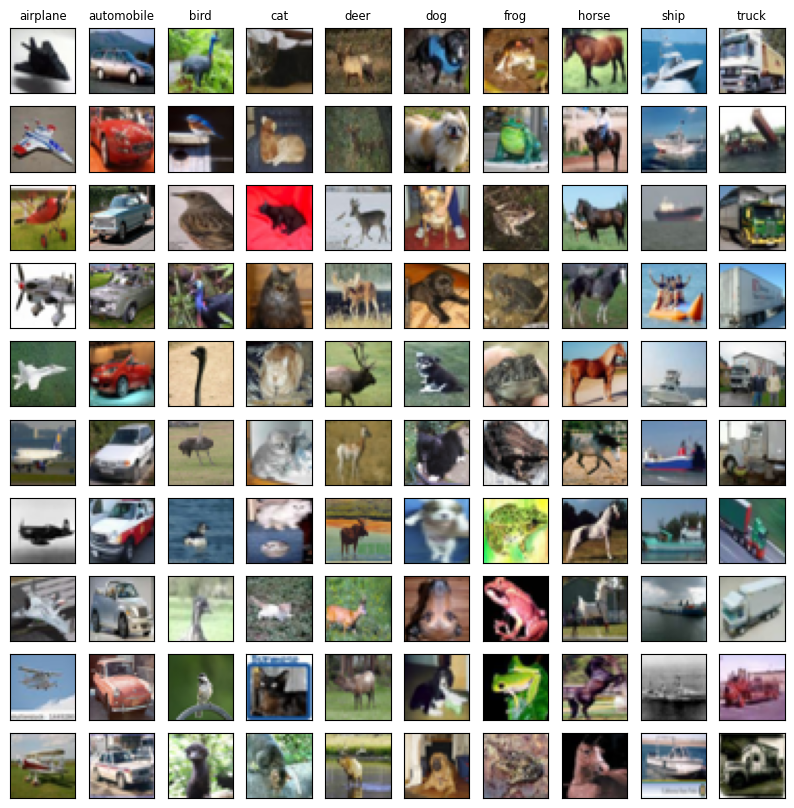

In [4]:
# Hint: To plot example images, you can use the plot examples function
plot_examples(X_train, y_train)

In [5]:
def normalize(images):
    mean = np.mean(images, axis=0)[np.newaxis]  # shape = (1, 32, 32, 3)
    sigma = np.std(images, axis=0)[np.newaxis]  # shape = (1, 32, 32, 3)
    images_normalized = (images - mean) / sigma
    return images_normalized

#In the instruction it is mentined that 20% of the training data should be used for validation, so that is what i do here.
#I also therefor wrote new code for the one hot encoding so that they would be in accordance with the split below.
#I hope this is ok.
X_val = X_train[40000:]
y_val = y_train[40000:]
X_train = X_train[:40000]
y_train = y_train[:40000]

# convert labels ("0"-"9") to one-hot encodings, "0" = (1, 0, ... 0) and so on
#y_train_onehot = tf.keras.utils.to_categorical(y_train, 10)
#y_test_onehot = tf.keras.utils.to_categorical(y_train, 10)[:8000]
#y_valid_onehot = tf.keras.utils.to_categorical(y_test, 10)[8000:]

# convert labels ("0"-"9") to one-hot encodings, "0" = (1, 0, ... 0) and so on
y_train_onehot = tf.keras.utils.to_categorical(y_train, 10)
y_test_onehot = tf.keras.utils.to_categorical(y_test, 10)
y_valid_onehot = tf.keras.utils.to_categorical(y_val, 10)

# Hint: normalize the data
# Hint: use 20% of the training data for validation


#Normalize all the data sets
X_train_norm = normalize(X_train)
X_test_norm = normalize(X_test)
X_val_norm = normalize(X_val)


print("x_train shape:", X_train.shape)
print(X_train.shape[0], "train samples")
print(X_val.shape[0], "validation samples")
print(X_test.shape[0], "test samples")

print("Example of x train")
print(X_train[0])

x_train shape: (40000, 32, 32, 3)
40000 train samples
10000 validation samples
10000 test samples
Example of x train
[[[ 59  62  63]
  [ 43  46  45]
  [ 50  48  43]
  ...
  [158 132 108]
  [152 125 102]
  [148 124 103]]

 [[ 16  20  20]
  [  0   0   0]
  [ 18   8   0]
  ...
  [123  88  55]
  [119  83  50]
  [122  87  57]]

 [[ 25  24  21]
  [ 16   7   0]
  [ 49  27   8]
  ...
  [118  84  50]
  [120  84  50]
  [109  73  42]]

 ...

 [[208 170  96]
  [201 153  34]
  [198 161  26]
  ...
  [160 133  70]
  [ 56  31   7]
  [ 53  34  20]]

 [[180 139  96]
  [173 123  42]
  [186 144  30]
  ...
  [184 148  94]
  [ 97  62  34]
  [ 83  53  34]]

 [[177 144 116]
  [168 129  94]
  [179 142  87]
  ...
  [216 184 140]
  [151 118  84]
  [123  92  72]]]


**CNN**
The Bonus CNN

In [6]:
# Hint: this code snipped shows how to define convolution and maxpooling layers. For more information see
# https://keras.io/api/layers/convolution_layers/convolution2d/
# https://keras.io/api/layers/pooling_layers/max_pooling2d/
act_fun = "relu"
reg_fac = 0.001
drop_rate_c = 0.2
drop_rate = 0.5

model = tf.keras.models.Sequential(
    [
        layers.Conv2D(16, kernel_size=(3, 3), padding="same", activation=act_fun, kernel_regularizer=regularizers.l2(reg_fac), input_shape=(32, 32, 3)),
        # add additional convolution layer and max pooling layer here,
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(32, kernel_size=(3, 3), padding="same", kernel_regularizer=regularizers.l2(reg_fac),activation=act_fun),
        layers.MaxPooling2D((2,2)),
        layers.Flatten(),
        Dropout(drop_rate),
        Dense(10, activation="softmax")
    ],
    name="cnn",
)

print(model.summary())

Model: "cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 8, 8, 32)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dropout (Dropout)           (None, 2048)              0       

In [10]:
def dense_block(x, n=3):
    """ Create a block of n densely connected pairs of convolutions """
    xlist = [x]
    for i in range(n):
        x = layers.Conv2D(8, (3, 3), padding='same', activation='relu')(x)
        xlist.append(x)
        x = layers.concatenate(xlist[:], axis=-1)
    return x

input_shape = (32, 32, 3)

x0 = Input(shape=input_shape, name='input') # some tensor of shape say (n, nx, ny, 64)
x = dense_block(x0)
x = layers.Conv2D(64, (1, 1), padding='same', activation='relu')(x)
x = layers.AveragePooling2D((2, 2), strides=(2, 2))(x)
x = dense_block(x)
x = layers.Conv2D(64, (1, 1), padding='same', activation='relu')(x)
x = layers.AveragePooling2D((2, 2), strides=(2, 2))(x)
x = GlobalAveragePooling2D(name='final_globalpooling')(x)
x = Dense(10, activation='softmax')(x)
model = keras.models.Model(inputs=[x0], outputs=[x], name='DenseNet')

print(model.summary())

Model: "DenseNet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv2d_20 (Conv2D)          (None, 32, 32, 8)            224       ['input[0][0]']               
                                                                                                  
 concatenate_16 (Concatenat  (None, 32, 32, 11)           0         ['input[0][0]',               
 e)                                                                  'conv2d_20[0][0]']           
                                                                                                  
 conv2d_21 (Conv2D)          (None, 32, 32, 8)            800       ['concatenate_16[0][0]'

In [11]:
# ----------------------------------------------------------
# Training
# ----------------------------------------------------------
loss_fun = "categorical_crossentropy"
learn_rate = 0.001
optim = "adam"
metric = "accuracy"


if optim == "adam":
    adam = keras.optimizers.Adam(learning_rate = learn_rate)
else:
    rmsprob = keras.optimizers.RMSprop(learning_rate = learn_rate)

model.compile(loss = loss_fun, 
              optimizer = optim, 
              metrics = [metric])

early_stopping = EarlyStopping(monitor="val_loss", 
                               patience = 20, 
                               verbose = 1, 
                               restore_best_weights=True)

# define callbacks for training
save_best = tf.keras.callbacks.ModelCheckpoint(
    "best_model_{}.h5".format(model.name),
    save_best_only=True,
    monitor="val_accuracy",
    save_weights_only=True,
)

model.fit(X_train_norm, 
          y_train_onehot,
          validation_data=(X_val_norm, y_valid_onehot),
          batch_size=128,
          epochs=20, # train at least for 20 epochs
          verbose=1,
          #validation_data=(x_valid_norm, y_valid_onehot),
          callbacks=[save_best, 
                     early_stopping,
                     tf.keras.callbacks.CSVLogger("history_{}.csv".format(model.name))]
)

Epoch 1/20
313/313 [==============================] - 441s 1s/step - loss: 1.8244 - accuracy: 0.3142 - val_loss: 1.6254 - val_accuracy: 0.3919
Epoch 2/20
 90/313 [=======>......................] - ETA: 4:56 - loss: 1.5750 - accuracy: 0.4186

KeyboardInterrupt: 

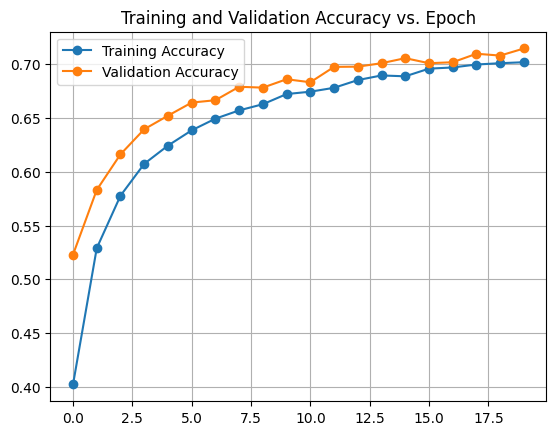

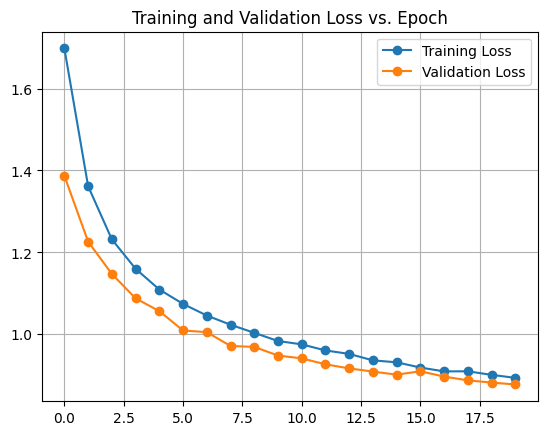

Model performance: 
|            |     Loss |   Accuracy |
|------------+----------+------------|
| Training   | 0.893361 |    70.1825 |
| Validation | 0.877209 |    71.46   |
| Test       | 0.877274 |    71.07   |


In [15]:
# ----------------------------------------------------------
# IMPORTED FROM 6.4 -- PLOT TRAIN AND VAL DURING TRAINING
# ----------------------------------------------------------
# load best model
model.load_weights(f"best_model_{model.name}.h5")

# plot training history
history = np.genfromtxt(f"history_{model.name}.csv", delimiter=",", names=True)
# add plots below

# Plot training and validation accuracy
plt.plot(history['epoch'], history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history['epoch'], history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy vs. Epoch')
plt.legend()
plt.grid(True)
plt.show()

# Plot training and validation loss
plt.plot(history['epoch'], history['loss'], label='Training Loss', marker='o')
plt.plot(history['epoch'], history['val_loss'], label='Validation Loss', marker='o')
plt.title('Training and Validation Loss vs. Epoch')
plt.legend()
plt.grid(True)
plt.show()

# Evaluate the model on the test dataset
#final_test_accuracy = model.evaluate(X_test_norm, y_test_onehot)[-1]*100
#print(f"Test Accuracy: ", final_test_accuracy)

print("Model performance: ")
headers = ["", "Loss", "Accuracy"]

table = [
    ["Training", history['loss'][-1], history['accuracy'][-1]*100],
    ["Validation", history['val_loss'][-1], history['val_accuracy'][-1]*100],
    ["Test", model.evaluate(X_test_norm, y_test_onehot, verbose=0,batch_size=128)[0], model.evaluate(X_test_norm, y_test_onehot, verbose=0,batch_size=128)[1]*100]
]
print(tabulate(table, headers=headers, tablefmt="orgtbl"))
#Print the final accuracies
#print("Final accuracy for training data: ", history['accuracy'][-1]*100)
#print("Final accuracy for validation data: ", history['val_accuracy'][-1]*100)

79/79 [==============================] - 1s 15ms/step


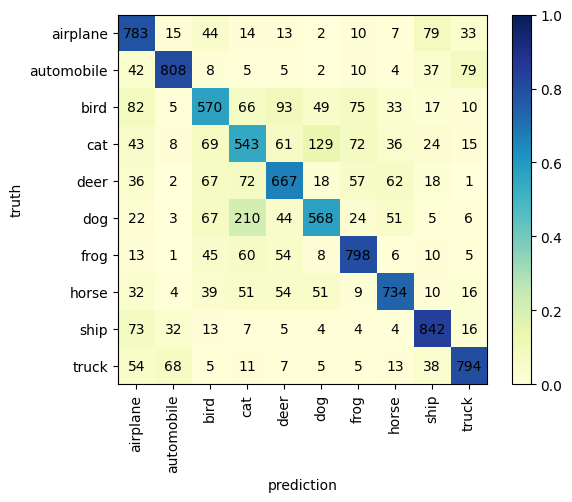

In [16]:
# ----------------------------------------------------------
# Plots
# ----------------------------------------------------------
# training curves
history = np.genfromtxt("history_{}.csv".format(model.name), delimiter=",", names=True)


# Hint: this is how you can plot the confusion matrix.
# calculate predictions for test set
y_predict = model.predict(X_test_norm, batch_size=128)

# convert back to class labels (0-9)
y_predict_cl = np.argmax(y_predict, axis=1)
y_test_cl = np.argmax(y_test_onehot, axis=1)

# plot confusion matrix
plot_confusion(y_test_cl, y_predict_cl)

(2893,) (7107,)


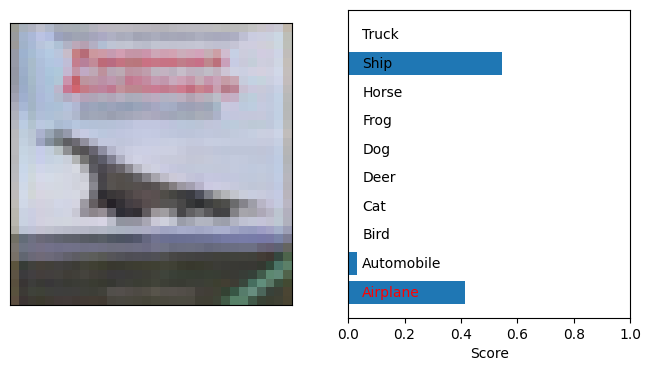

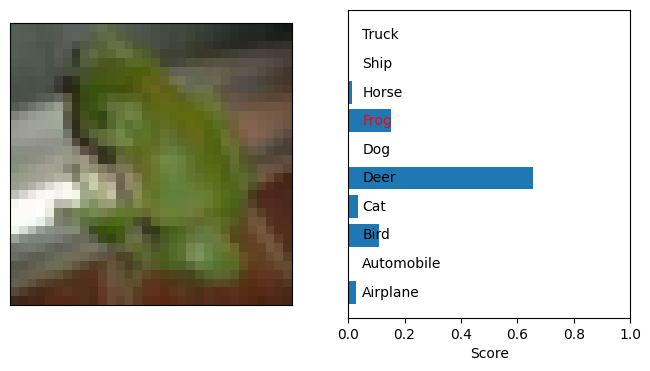

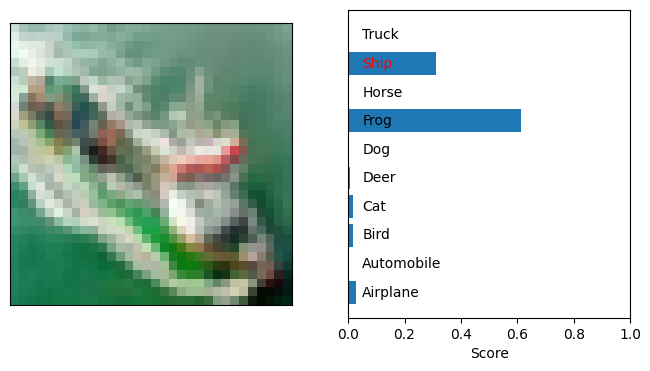

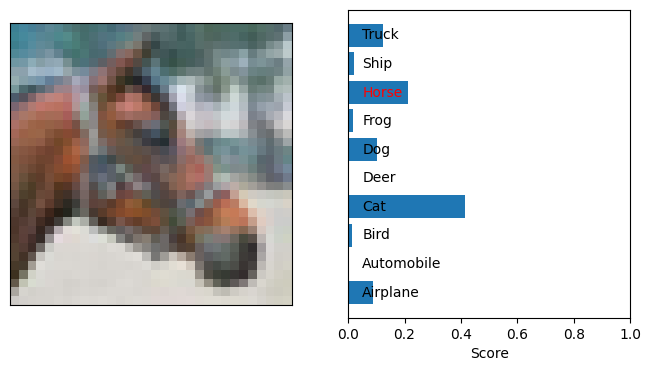

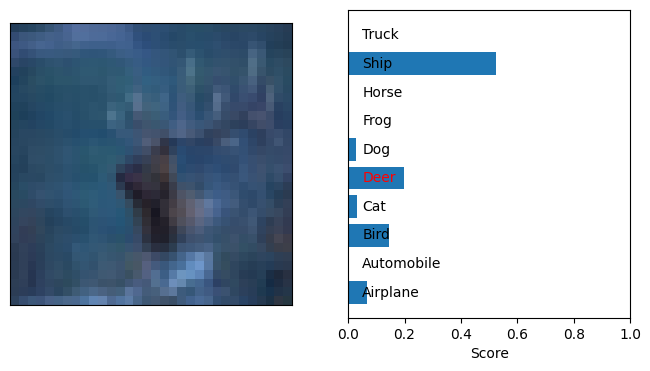

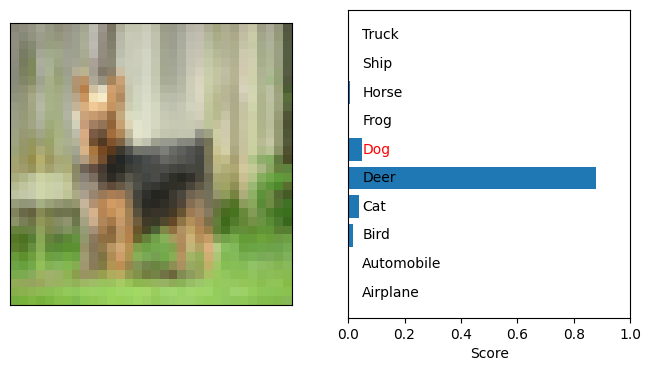

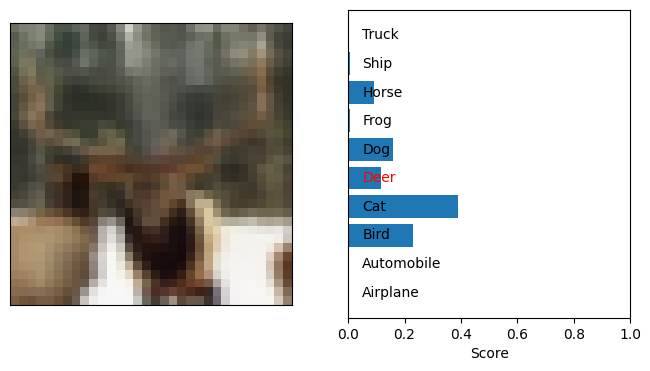

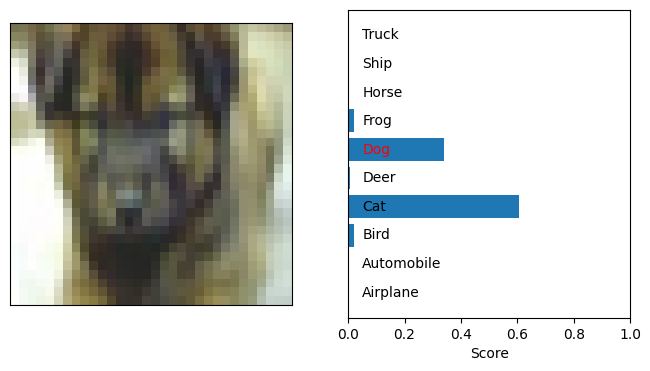

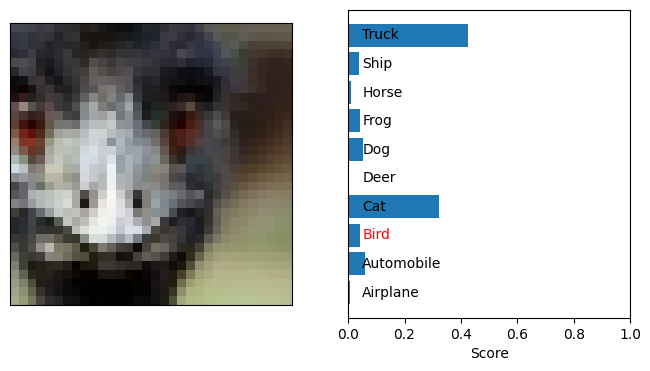

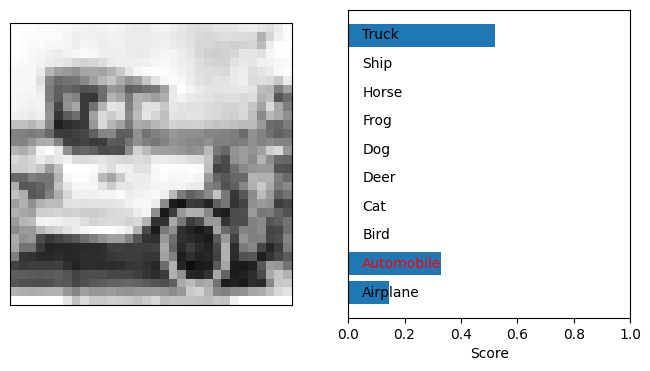

In [17]:
# Task: plot a few examples of correctly and incorrectly classified images.
# Hint: First find the indices of correctly and incorrectly classified images:
m = y_predict_cl == y_test_cl
i0 = np.arange(10000)[~m]  # misclassified images
i1 = np.arange(10000)[m]  # correctly classified images
print(i0.shape, i1.shape)

# original (unnormalized) test images
#x_test = X_test[:8000]

# Hint: Now you can use the `plot_prediction` function to plot the images:
# plot first 10 false classifications
for i in i0[0:10]:
    plot_prediction(X_test[i], y_test_onehot[i], y_predict[i])

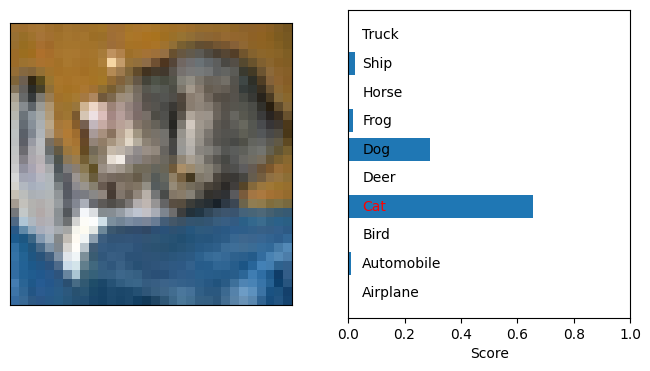

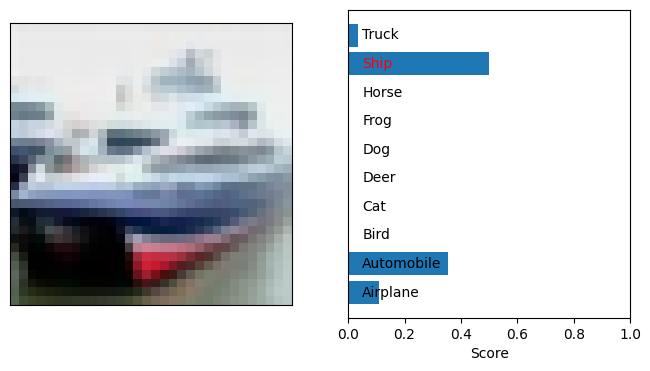

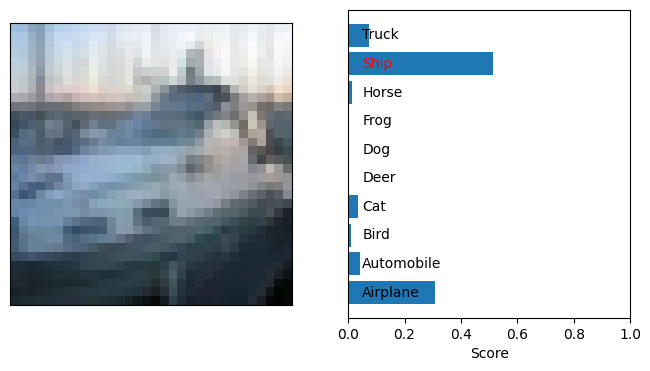

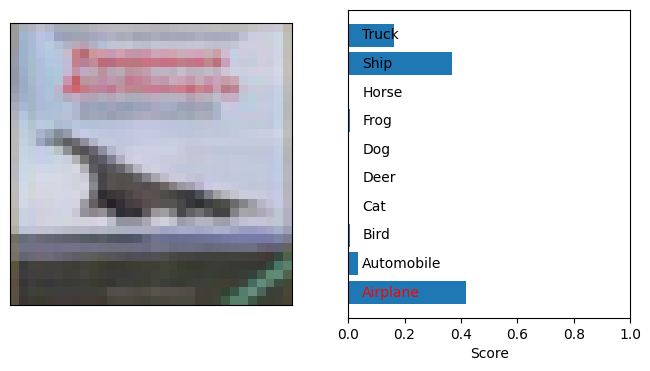

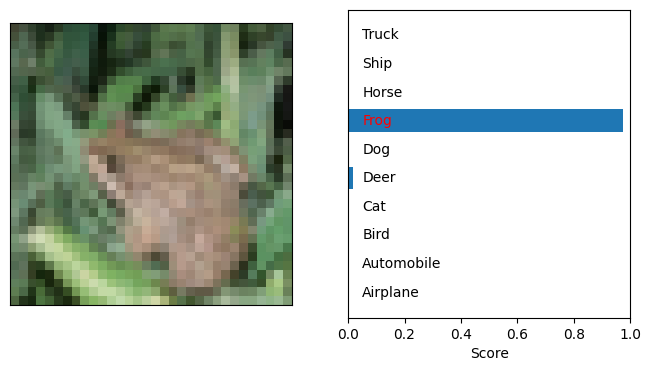

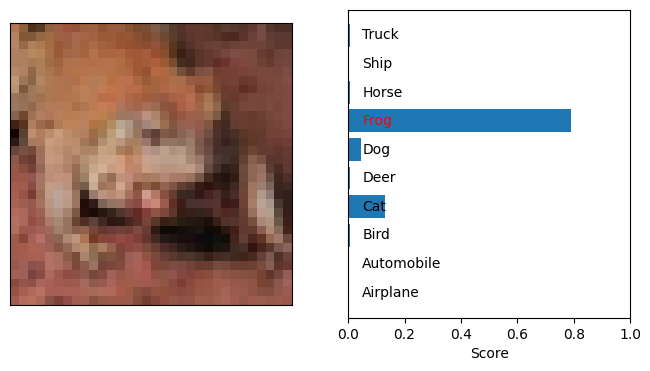

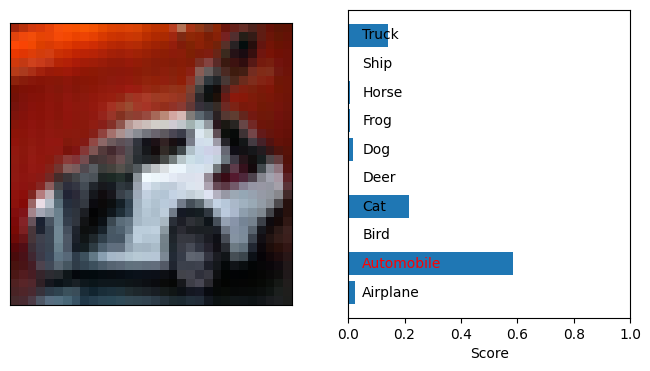

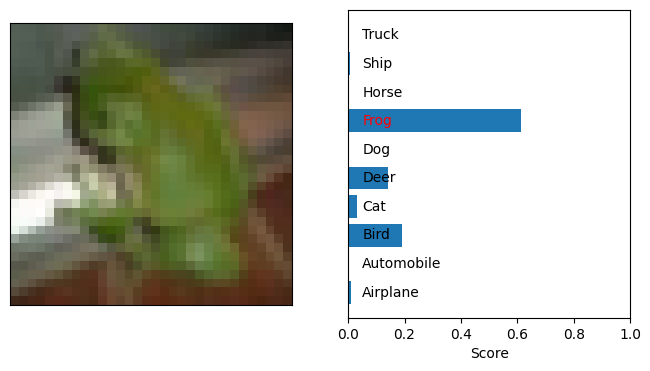

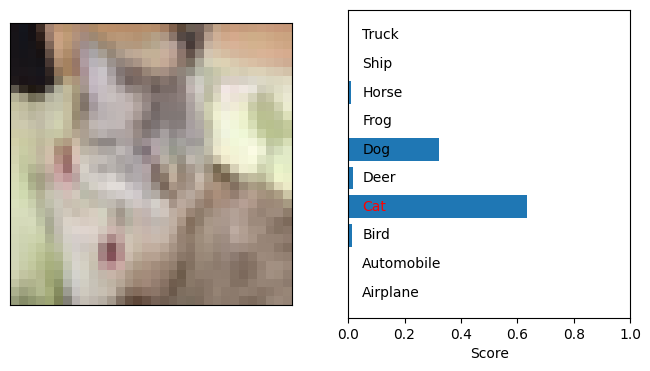

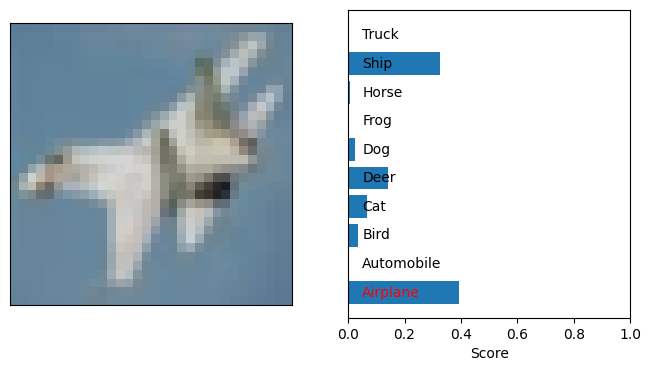

In [ ]:
for i in i1[0:10]:
    plot_prediction(X_test[i], y_test_onehot[i], y_predict[i])